In [1]:
from lightgbm import LGBMRegressor
from data import *
from model import *

taxi_type = YELLOW
train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = LGBMRegressor(n_estimators=1000, 
                      learning_rate=0.5, 
                      max_depth=9)

# Training
with DR.engn.connect() as conn:
    processed = 0
    for df in pd.read_sql(train_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y = df[VARIABLE]

        model.fit(X, y)
        O.out(f'Trained {processed} rows')

storeModel(model, f'{taxi_type}_{VARIABLE}_{LIGHT_GBM_REGRESSOR}')

# Predictions
with DR.engn.connect() as conn:
    processed = 0
    y_test = []
    y_pred = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y_test.append(df[VARIABLE])

        y_pred.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

# Performance
merged_y_test = pd.concat(y_test, ignore_index=True)
merged_y_pred = np.concatenate(y_pred)

showPerformance(merged_y_test, merged_y_pred)

sql engine ready
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1266
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 11
[LightGBM] [Info] Start training from score 12.211021
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1226
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 11
[LightGBM] [Info] Start training from score 11.735073
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Li

sql engine ready
Mean Squared Error: 5.146957783358888


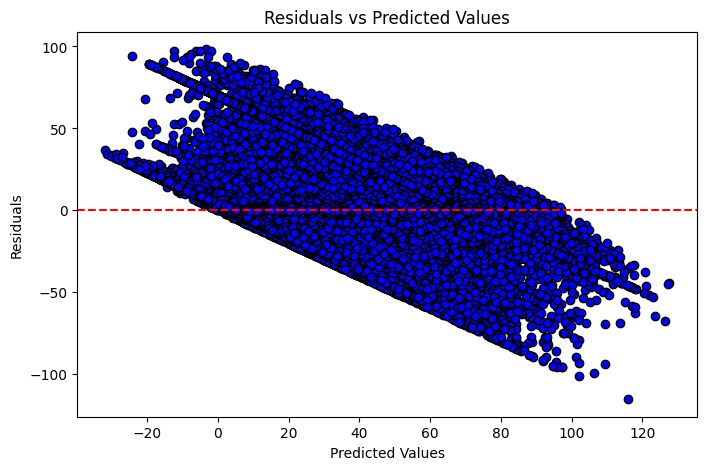

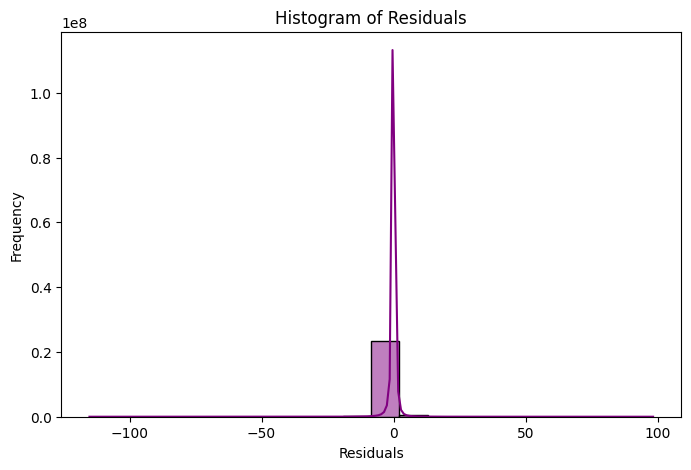

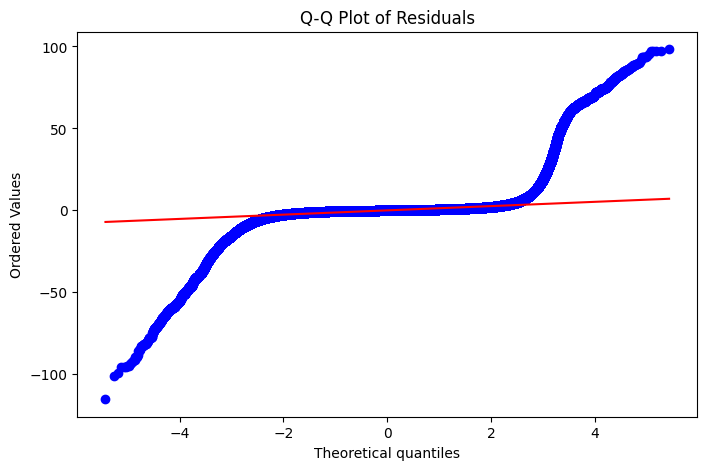

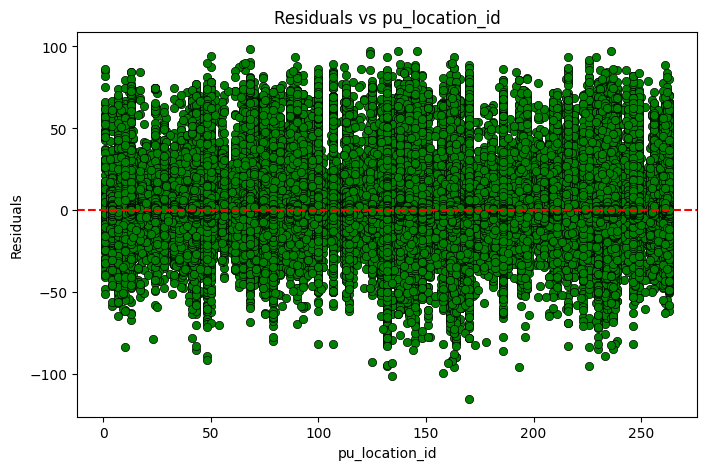

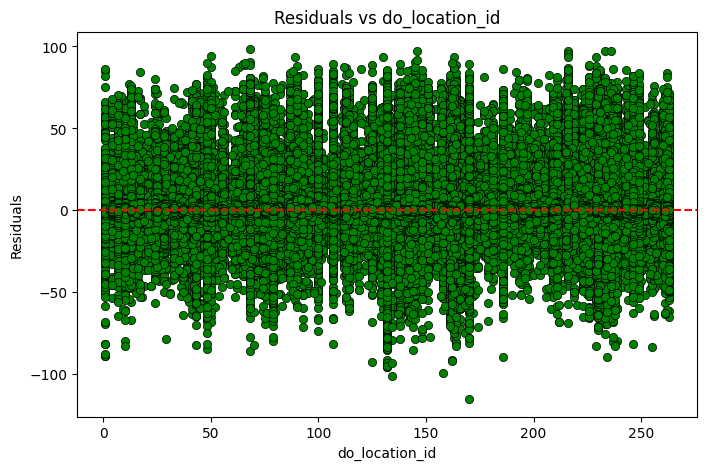

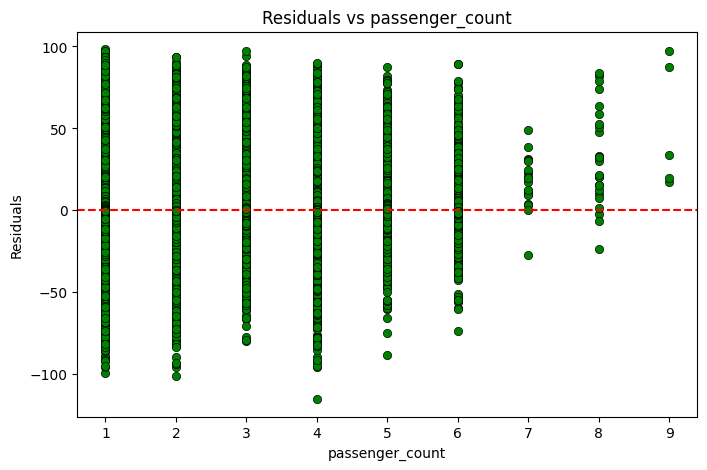

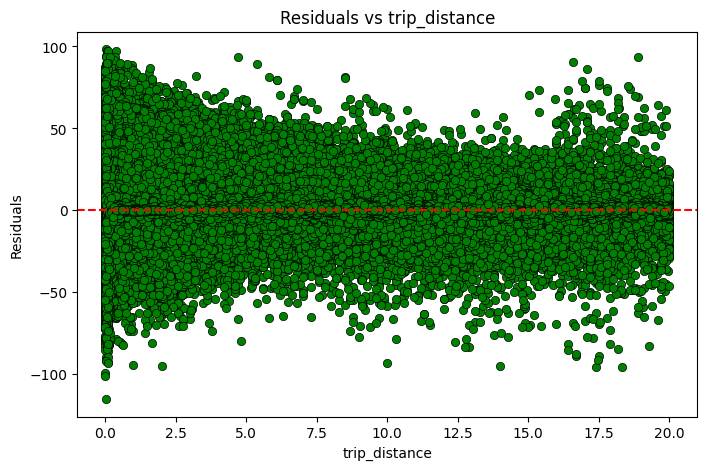

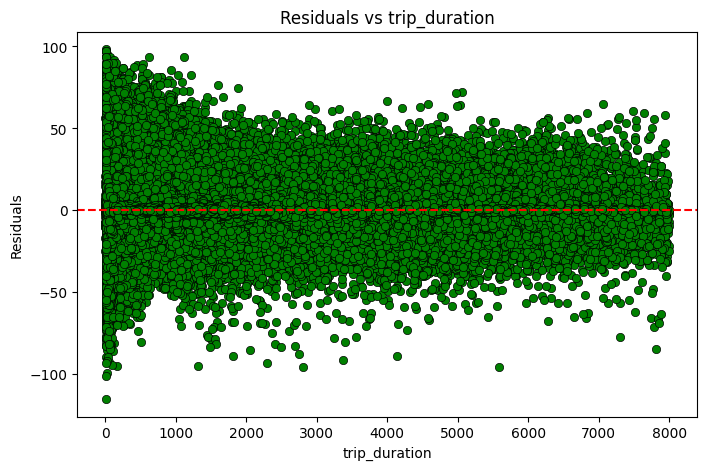

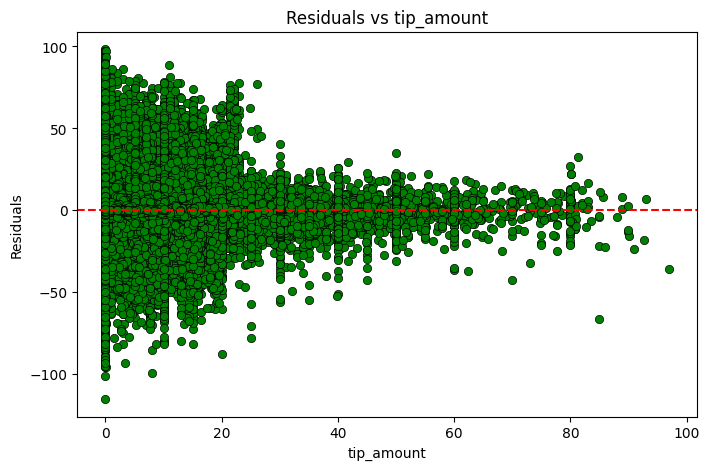

In [ ]:
# Residual Analysis
from data import *
from model import *

taxi_type = YELLOW
# train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = loadModel(f'{taxi_type}_{VARIABLE}_{LIGHT_GBM_REGRESSOR}')

# Predictions
with DR.engn.connect() as conn:
    processed = 0
    y_t_chunk = []
    y_p_chunk = []
    X_t_chunk = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        X_t_chunk.append(X)
        y_t_chunk.append(df[VARIABLE])

        y_p_chunk.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

# Performance
X_test = pd.concat(X_t_chunk, ignore_index=True)
y_test = pd.concat(y_t_chunk, ignore_index=True)
y_pred = np.concatenate(y_p_chunk)


residualAnalysis(X_test, y_test, y_pred)